In [3]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [4]:
env = BlackjackEnv()

In [5]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        """
        policy = 
         - epsilon/nA + (1 - epsilon) if best action
         - epsilon/nA                 otherwise
        """
        A= np.ones(nA, dtype=float)*epsilon/nA
        best_action= np.argmax(Q[observation])
        A[best_action]+= (1 - epsilon) 
        return A
        
    return policy_fn

In [10]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # generate episodes
    for i_episode in range(1,num_episodes+1):   
        if i_episode%10000==0:
            print("generate episode %d..."%(i_episode))
        # generate an episode
        episode= []
        state= env.reset()
        for t in range(100):
            # get epsilon greedy policy for current state
            probs= policy(state)
            #pdb.set_trace()
            # select action based on the epsilon greedy policy
            action= np.random.choice(np.arange(len(probs)), p= probs)
            # run one step and get next state
            next_state, reward, done, _ = env.step(action)
            # add to episode
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        # for every visited (state,action) pair, update Q value
        sa_in_episode= set([(x[0], x[1]) for x in episode])
        for state,action in sa_in_episode:
            sa_pair= (state,action)
            # find out the first occurence index
            first_occur_idx= next(i for i,x in enumerate(episode) if x[0]==state and x[1]==action)
            # calculate return to the end of episode
            Gt= sum([x[2]*discount_factor**i for i,x in enumerate(episode[first_occur_idx:])])

            returns_count[sa_pair]+= 1.0
            returns_sum[sa_pair]+= Gt
            Q[state][action]= returns_sum[sa_pair]/returns_count[sa_pair]    
        
    
    return Q, policy

In [11]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

generate episode 10000...
generate episode 20000...
generate episode 30000...
generate episode 40000...
generate episode 50000...
generate episode 60000...
generate episode 70000...
generate episode 80000...
generate episode 90000...
generate episode 100000...
generate episode 110000...
generate episode 120000...
generate episode 130000...
generate episode 140000...
generate episode 150000...
generate episode 160000...
generate episode 170000...
generate episode 180000...
generate episode 190000...
generate episode 200000...
generate episode 210000...
generate episode 220000...
generate episode 230000...
generate episode 240000...
generate episode 250000...
generate episode 260000...
generate episode 270000...
generate episode 280000...
generate episode 290000...
generate episode 300000...
generate episode 310000...
generate episode 320000...
generate episode 330000...
generate episode 340000...
generate episode 350000...
generate episode 360000...
generate episode 370000...
generate e

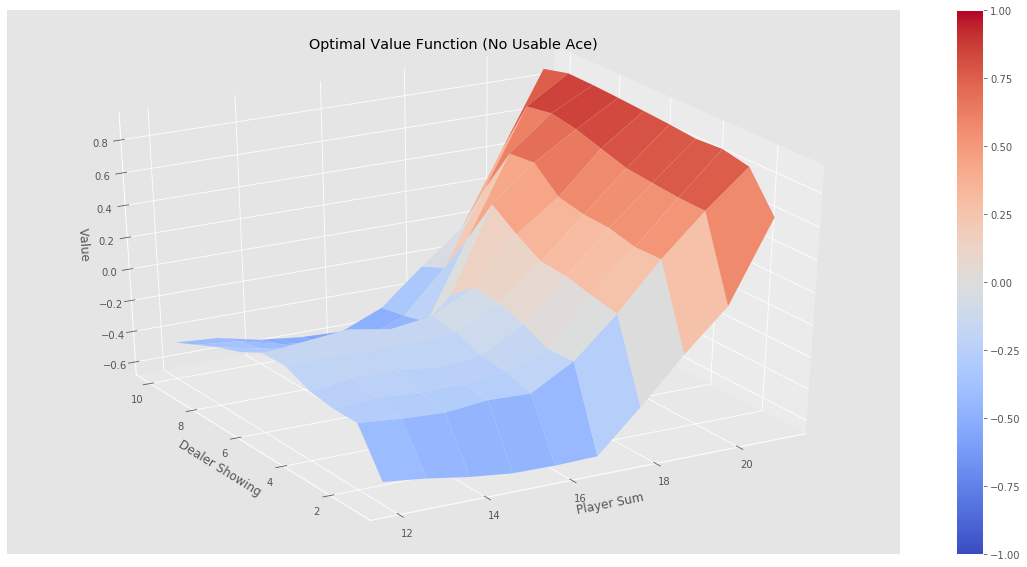

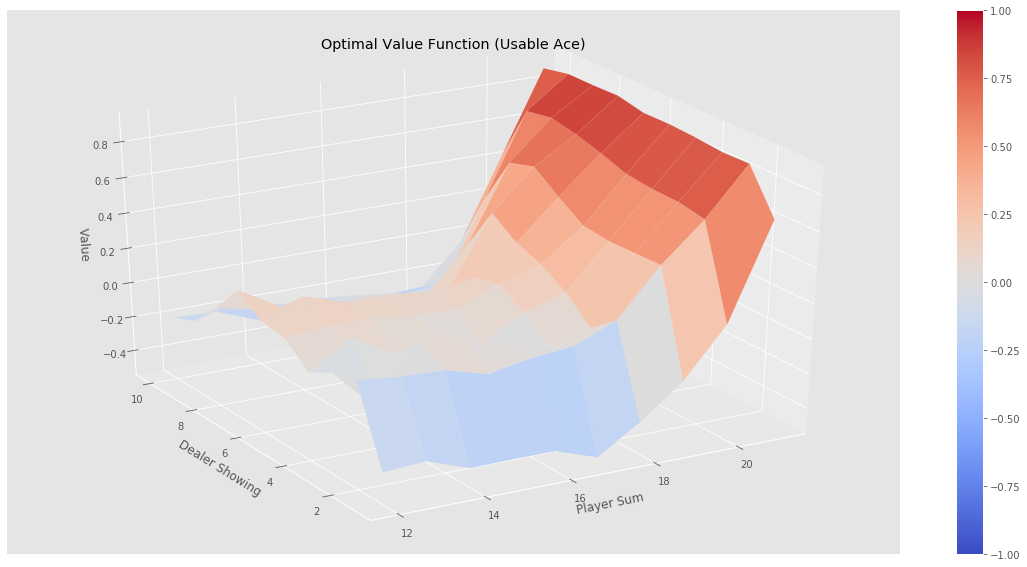

In [12]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")